# Ames Housing Dataset -  Feature Encoding and Selection

> Gianmaria Pizzo - 872966@stud.unive.it

These notebooks represent the project submission for the course [Data and Web Mining](https://www.unive.it/data/course/337525) by Professor [Claudio Lucchese](https://www.unive.it/data/people/5590426) at [Ca' Foscari University of Venice](https://www.unive.it).

---

## Structure of this notebook

This notebook covers the following points
* Feature Selection (from domain knowledge and previous evidence)
* Categorical Feature Encoding
* Feature Importance (assessed through some models)
* Type Conversion
* Final Dataset Overview

---

### Before running this notebook

To avoid issues, before running the following notebook it is best to
* Clean previous cell outputs
* Restart the kernel

---

###  Environment, Imports and Global Variables

In [1]:
# Interactive
%matplotlib notebook
# Static
# %matplotlib inline

# Environment for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import IPython

# Set the style for the plots
sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
# Ignore warnings
warnings.filterwarnings('ignore') 

In [2]:
# Working folder
WORKING_DIR = os.getcwd()
# Resources folder
RESOURCES_DIR = os.path.join(os.getcwd(), 'resources')
# Name of file
IN_LABEL = 'ames_housing_out_1.csv'
ORIG_LABEL = 'ames_housing_out_1_orig.csv'

In [3]:
df = pd.read_csv(os.path.join(RESOURCES_DIR, IN_LABEL))
df_orig = pd.read_csv(os.path.join(RESOURCES_DIR, ORIG_LABEL))

df.drop(columns='Unnamed: 0', inplace=True)
df_orig.drop(columns='Unnamed: 0', inplace=True)

In [4]:
def sort_alphabetically(dataset, last_label = None):
    """
    Sorts the dataset alphabetically 

    :param dataset: a pd.DataFrame
    :param last_label: a str containing an existing column label in the dataset
    :returns: pd.DataFrame
    """
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    if last_label is not None:
        col = dataset.pop(last_label)
        dataset.insert(dataset.shape[1], last_label, col)
    return dataset

In [5]:
df = sort_alphabetically(df, 'Sale_Price')
df_orig = sort_alphabetically(df_orig, 'Sale_Price')

---

## Removing obvious misleading and irrelevant attributes

From our previous analysis we have some level of insight about what features we want to consider.
* We are obviously going to remove the `Latitude` and `Logitude` as these feature are most likely leading to overfitting.
* Other features such as `Bldg_Type`,`Exterior_1st`, `Exterior_2nd`, `Foundation`,`Utilities`, `Heating_QC`, `House_Style`, `Lot_Config`, `Lot_Shape`,`Mas_Vnr_Type`, are not really useful from what we learnt
* Others were the result of the combinations or transformations of initial features
* And some others need to be encoded first

In [6]:
def drop_if_exists(dataset, to_drop):
    for f in to_drop:
        if f in list(dataset.columns):
            dataset.drop(columns = f, inplace=True)
    pass

In [7]:
to_drop = ['Bldg_Type', 'Exterior_1st', 'Exterior_2nd', 'Foundation',
           'Utilities', 'Heating_QC', 'House_Style', 'Lot_Config', 'Lot_Shape', 'Land_Contour',
           'Fence','Mas_Vnr_Type', 'Latitude', 'Longitude', 'Utilities', 'Paved_Drive']

In [8]:
drop_if_exists(df, to_drop=to_drop)
drop_if_exists(df_orig, to_drop=to_drop)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 72 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2638 non-null   float64
 1   Bedroom_AbvGr            2638 non-null   float64
 2   Bedroom_Liv_Area_Ratio   2638 non-null   float64
 3   Bsmt                     2638 non-null   int64  
 4   BsmtFin_SF_1             2638 non-null   float64
 5   BsmtFin_SF_2             2638 non-null   float64
 6   BsmtFin_Type_1           2638 non-null   object 
 7   BsmtFin_Type_2           2638 non-null   object 
 8   Bsmt_Cond                2638 non-null   object 
 9   Bsmt_Exposure            2638 non-null   object 
 10  Bsmt_Full_Bath           2638 non-null   float64
 11  Bsmt_Half_Bath           2638 non-null   float64
 12  Bsmt_Qual                2638 non-null   object 
 13  Bsmt_Unf_SF              2638 non-null   float64
 14  Central_Air             

In [10]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 86 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2930 non-null   float64
 1   Alley                    2930 non-null   object 
 2   Bedroom_AbvGr            2930 non-null   float64
 3   Bedroom_Liv_Area_Ratio   2930 non-null   float64
 4   Bsmt                     2930 non-null   int64  
 5   BsmtFin_SF_1             2930 non-null   float64
 6   BsmtFin_SF_2             2930 non-null   float64
 7   BsmtFin_Type_1           2930 non-null   object 
 8   BsmtFin_Type_2           2930 non-null   object 
 9   Bsmt_Cond                2930 non-null   object 
 10  Bsmt_Exposure            2930 non-null   object 
 11  Bsmt_Full_Bath           2930 non-null   float64
 12  Bsmt_Half_Bath           2930 non-null   float64
 13  Bsmt_Qual                2930 non-null   object 
 14  Bsmt_Unf_SF             

---

## Categorical Feature Encoding

### Ordinal Feature Encoding

As principle that guides us to classify a feature as ordinal is the usage of the words "Quality" or "Condition", and the presence of levels in between two extremes.

In certain cases, we might choose not to adopt a conventional approach as some variables have most instances in a single category, which then makes that the 'average' category. However, here we trust the levels given by the description of the features.

As I said before, each one of those features have their own scale, centering the encoding around the mode would be the best option for some cases.

https://datascience.stackexchange.com/questions/72343/encoding-with-ordinalencoder-how-to-give-levels-as-user-input

In [11]:
%%html --isolated

<style type="text/css">.tg-sort-header::-moz-selection{background:0 0}.tg-sort-header::selection{background:0 0}.tg-sort-header{cursor:pointer}.tg-sort-header:after{content:'';float:right;margin-top:7px;border-width:0 5px 5px;border-style:solid;border-color:#404040 transparent;visibility:hidden}.tg-sort-header:hover:after{visibility:visible}.tg-sort-asc:after,.tg-sort-asc:hover:after,.tg-sort-desc:after{visibility:visible;opacity:.4}.tg-sort-desc:after{border-bottom:none;border-width:5px 5px 0}@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;margin: auto 0px;}}</style><div class="tg-wrap"><table id="tg-oyTCE" style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;margin:0px auto" class="tg"><thead><tr><th style="background-color:#409cff;border-color:inherit;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:left;top:-1px;vertical-align:top;will-change:transform;word-break:normal"><span style="font-weight:bold">Feature</span></th><th style="background-color:#409cff;border-color:inherit;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:center;top:-1px;vertical-align:top;will-change:transform;word-break:normal"><span style="font-weight:bold">Meaning</span></th></tr></thead><tbody><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">BsmtFin_Type_1</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Rating of basement finished area</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">BsmtFin_Type_2</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Rating of basement finished area (if multiple types)</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Bsmt_Cond</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Evaluates the general condition of the basement</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Bsmt_Exposure</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Refers to walkout or garden level walls</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Bsmt_Qual</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Evaluates the height of the basement</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exter_Cond</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Evaluates the present condition of the material on the exterior</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exter_Qual</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Evaluates the quality of the material on the exterior</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fence</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fence quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fireplace_Qu</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fireplace quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Functional</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Home functionality (Assume typical unless deductions are warranted)</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage_Cond</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage condition</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage_Finish</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Interior finish of the garage</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage_Qual</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Heating_QC</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Heating quality and condition</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Kitchen_Qual</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Kitchen quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Land_Contour</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Flatness of the property</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Land_Slope</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Slope of property</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Lot_Shape</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">General shape of property</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Overall_Cond</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Rates the overall condition of the house</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Overall_Qual</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Rates the overall material and finish of the house</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Paved_Drive</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Paved driveway</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Pool_QC</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Pool quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Utilities</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of utilities available</td></tr></tbody></table></div><script charset="utf-8">var TGSort=window.TGSort||function(n){"use strict";function r(n){return n?n.length:0}function t(n,t,e,o=0){for(e=r(n);o<e;++o)t(n[o],o)}function e(n){return n.split("").reverse().join("")}function o(n){var e=n[0];return t(n,function(n){for(;!n.startsWith(e);)e=e.substring(0,r(e)-1)}),r(e)}function u(n,r,e=[]){return t(n,function(n){r(n)&&e.push(n)}),e}var a=parseFloat;function i(n,r){return function(t){var e="";return t.replace(n,function(n,t,o){return e=t.replace(r,"")+"."+(o||"").substring(1)}),a(e)}}var s=i(/^(?:\s*)([+-]?(?:\d+)(?:,\d{3})*)(\.\d*)?$/g,/,/g),c=i(/^(?:\s*)([+-]?(?:\d+)(?:\.\d{3})*)(,\d*)?$/g,/\./g);function f(n){var t=a(n);return!isNaN(t)&&r(""+t)+1>=r(n)?t:NaN}function d(n){var e=[],o=n;return t([f,s,c],function(u){var a=[],i=[];t(n,function(n,r){r=u(n),a.push(r),r||i.push(n)}),r(i)<r(o)&&(o=i,e=a)}),r(u(o,function(n){return n==o[0]}))==r(o)?e:[]}function v(n){if("TABLE"==n.nodeName){for(var a=function(r){var e,o,u=[],a=[];return function n(r,e){e(r),t(r.childNodes,function(r){n(r,e)})}(n,function(n){"TR"==(o=n.nodeName)?(e=[],u.push(e),a.push(n)):"TD"!=o&&"TH"!=o||e.push(n)}),[u,a]}(),i=a[0],s=a[1],c=r(i),f=c>1&&r(i[0])<r(i[1])?1:0,v=f+1,p=i[f],h=r(p),l=[],g=[],N=[],m=v;m<c;++m){for(var T=0;T<h;++T){r(g)<h&&g.push([]);var C=i[m][T],L=C.textContent||C.innerText||"";g[T].push(L.trim())}N.push(m-v)}t(p,function(n,t){l[t]=0;var a=n.classList;a.add("tg-sort-header"),n.addEventListener("click",function(){var n=l[t];!function(){for(var n=0;n<h;++n){var r=p[n].classList;r.remove("tg-sort-asc"),r.remove("tg-sort-desc"),l[n]=0}}(),(n=1==n?-1:+!n)&&a.add(n>0?"tg-sort-asc":"tg-sort-desc"),l[t]=n;var i,f=g[t],m=function(r,t){return n*f[r].localeCompare(f[t])||n*(r-t)},T=function(n){var t=d(n);if(!r(t)){var u=o(n),a=o(n.map(e));t=d(n.map(function(n){return n.substring(u,r(n)-a)}))}return t}(f);(r(T)||r(T=r(u(i=f.map(Date.parse),isNaN))?[]:i))&&(m=function(r,t){var e=T[r],o=T[t],u=isNaN(e),a=isNaN(o);return u&&a?0:u?-n:a?n:e>o?n:e<o?-n:n*(r-t)});var C,L=N.slice();L.sort(m);for(var E=v;E<c;++E)(C=s[E].parentNode).removeChild(s[E]);for(E=v;E<c;++E)C.appendChild(s[v+L[E-v]])})})}}n.addEventListener("DOMContentLoaded",function(){for(var t=n.getElementsByClassName("tg"),e=0;e<r(t);++e)try{v(t[e])}catch(n){}})}(document)</script>

BsmtFin_Type_1,Rating of basement finished area
BsmtFin_Type_2,Rating of basement finished area (if multiple types)
Bsmt_Cond,Evaluates the general condition of the basement
Bsmt_Exposure,Refers to walkout or garden level walls
Bsmt_Qual,Evaluates the height of the basement
Exter_Cond,Evaluates the present condition of the material on the exterior
Exter_Qual,Evaluates the quality of the material on the exterior
Fence,Fence quality
Fireplace_Qu,Fireplace quality
Functional,Home functionality (Assume typical unless deductions are warranted)
Garage_Cond,Garage condition


In [12]:
from sklearn.preprocessing import OrdinalEncoder

def remove_byte_str(dataset):
    """
    Removes the byte string part "b'" from the categorical features
    : param dataset: a pandas.DataFrame
    : returns: None
    """
    categorical = dataset.select_dtypes(object)
    for col in categorical:
        categorical[[col]] = categorical[[col]].apply(lambda x: x.str.replace("b'", "").str.replace("'", ""))
        dataset[col] = categorical[col]
    pass

def ordinal_encoding(dataset, ord_mapping):
    columns = list(dataset.columns)
    for col in ord_mapping:
            label = list(col.keys())[0]
            if label in columns:
                ordered_values = col.get(label)
                encoder = OrdinalEncoder(categories=[ordered_values])
                dataset[[label]] = encoder.fit_transform(dataset[[label]])
            else:
                continue
    pass


In [13]:
df_orig1 = df_orig.copy()
df1 = df.copy()
remove_byte_str(dataset = df_orig1)
remove_byte_str(dataset = df1)

In [14]:
orig_mapping = [
    {'BsmtFin_Type_1':['No_Basement', 'Unf', 'LwQ','Rec', 'BLQ', 'ALQ', 'GLQ']},
    {'BsmtFin_Type_2':['No_Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']},
    {'Bsmt_Cond': ['No_Basement', 'Poor', 'Fair', 'Typical','Good','Excellent']},
    {'Bsmt_Exposure':['No_Basement', 'No', 'Mn', 'Av','Gd']},
    {'Bsmt_Qual':['No_Basement', 'Poor', 'Fair', 'Typical', 'Good', 'Excellent']},
    {'Exter_Cond':[ 'Poor', 'Fair', 'Typical', 'Good',  'Excellent']},
    {'Exter_Qual':['Fair', 'Typical', 'Good',  'Excellent']},
    {'Fence':['No_Fence', 'Minimum_Wood_Wire', 'Good_Wood','Minimum_Privacy', 'Good_Privacy']},
    {'Fireplace_Qu':['No_Fireplace','Poor',  'Fair', 'Typical','Good', 'Excellent']},
    {'Functional':['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2','Min1','Typ' ]},
    {'Garage_Cond':['No_Garage', 'Poor', 'Fair','Typical', 'Good','Excellent']},
    {'Garage_Finish':['No_Garage','Unf', 'RFn', 'Fin', 'Typical']},
    {'Garage_Qual':['No_Garage','Poor' , 'Fair','Typical', 'Good', 'Excellent']},
    {'Heating_QC':['Poor', 'Fair', 'Typical', 'Good',  'Excellent']},
    {'Kitchen_Qual':['Poor', 'Fair', 'Typical', 'Good',  'Excellent']},
    {'Land_Contour':['Low','HLS','Bnk','Lvl']},
    {'Land_Slope':['Sev', 'Mod', 'Gtl']},
    {'Lot_Shape':['Irregular', 'Moderately_Irregular', 'Slightly_Irregular', 'Regular']},
    {'Overall_Cond':[ 'Very_Poor', 'Poor', 'Fair', 'Below_Average', 'Average', 'Above_Average', 'Good', 'Very_Good', 'Excellent']},
    {'Overall_Qual':['Very_Poor', 'Poor','Fair', 'Below_Average', 'Average', 'Above_Average', 'Good', 'Very_Good', 'Excellent', 'Very_Excellent']},
    {'Paved_Drive':['Dirt_Gravel', 'Partial_Pavement', 'Paved']},
    {'Pool_QC':['No_Pool', 'Fair', 'Typical', 'Good', 'Excellent']}]

In [15]:
ordinal_encoding(dataset=df_orig1, ord_mapping = orig_mapping)
df_orig_alt = df_orig1.copy()

In [16]:
ordinal_encoding(dataset=df1, ord_mapping = orig_mapping)
df_alt = df1.copy()

### Nominal Feature Encoding

These features are very easy to recognize as they give us no hint of an "order" in their levels.

We prefer to use a One-Hot encoding for these variables from which we obtain a series of binary variables (1 or 0) representing whether or not a category was present for a particular row. However, this is not a good way to encode features which have a lot of labels. This is why we will try to find a better way for our prediction.

In [17]:
%%html --isolated
<style type="text/css">.tg-sort-header::-moz-selection{background:0 0}.tg-sort-header::selection{background:0 0}.tg-sort-header{cursor:pointer}.tg-sort-header:after{content:'';float:right;margin-top:7px;border-width:0 5px 5px;border-style:solid;border-color:#404040 transparent;visibility:hidden}.tg-sort-header:hover:after{visibility:visible}.tg-sort-asc:after,.tg-sort-asc:hover:after,.tg-sort-desc:after{visibility:visible;opacity:.4}.tg-sort-desc:after{border-bottom:none;border-width:5px 5px 0}@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;margin: auto 0px;}}</style><div class="tg-wrap"><table id="tg-qpwKN" style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;margin:0px auto" class="tg"><thead><tr><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:left;top:-1px;vertical-align:top;will-change:transform;word-break:normal"><span style="font-weight:bold">Feature</span></th><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:center;top:-1px;vertical-align:top;will-change:transform;word-break:normal"><span style="font-weight:bold">Meaning</span></th></tr></thead><tbody><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Alley</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of alley access</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Bldg_Type</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of dwelling</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Condition_1</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Proximity to various conditions</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Condition_2</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Proximity to various conditions (if more than one is present)</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Electrical</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Electrical system</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exterior_1st</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exterior covering on house</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exterior_2nd</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exterior covering on house</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Foundation</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of foundation</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage_Type</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage location</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Heating</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of heating</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">House_Style</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Style of dwelling</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Lot_Config</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Lot Configuration</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Mas_Vnr_Type</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Masonry veneer type</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">MS_SubClass</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Identifies the type of dwelling involved in the sale.</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">MS_Zoning</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Identifies the general zoning classification of the sale.</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Neighborhood</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Physical locations within Ames city limits</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Roof_Matl</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Roof Material</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Roof_Style</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of roof</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Sale_Condition</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Condition of sale</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Sale_Type</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of sale</td></tr></tbody></table></div><script charset="utf-8">var TGSort=window.TGSort||function(n){"use strict";function r(n){return n?n.length:0}function t(n,t,e,o=0){for(e=r(n);o<e;++o)t(n[o],o)}function e(n){return n.split("").reverse().join("")}function o(n){var e=n[0];return t(n,function(n){for(;!n.startsWith(e);)e=e.substring(0,r(e)-1)}),r(e)}function u(n,r,e=[]){return t(n,function(n){r(n)&&e.push(n)}),e}var a=parseFloat;function i(n,r){return function(t){var e="";return t.replace(n,function(n,t,o){return e=t.replace(r,"")+"."+(o||"").substring(1)}),a(e)}}var s=i(/^(?:\s*)([+-]?(?:\d+)(?:,\d{3})*)(\.\d*)?$/g,/,/g),c=i(/^(?:\s*)([+-]?(?:\d+)(?:\.\d{3})*)(,\d*)?$/g,/\./g);function f(n){var t=a(n);return!isNaN(t)&&r(""+t)+1>=r(n)?t:NaN}function d(n){var e=[],o=n;return t([f,s,c],function(u){var a=[],i=[];t(n,function(n,r){r=u(n),a.push(r),r||i.push(n)}),r(i)<r(o)&&(o=i,e=a)}),r(u(o,function(n){return n==o[0]}))==r(o)?e:[]}function v(n){if("TABLE"==n.nodeName){for(var a=function(r){var e,o,u=[],a=[];return function n(r,e){e(r),t(r.childNodes,function(r){n(r,e)})}(n,function(n){"TR"==(o=n.nodeName)?(e=[],u.push(e),a.push(n)):"TD"!=o&&"TH"!=o||e.push(n)}),[u,a]}(),i=a[0],s=a[1],c=r(i),f=c>1&&r(i[0])<r(i[1])?1:0,v=f+1,p=i[f],h=r(p),l=[],g=[],N=[],m=v;m<c;++m){for(var T=0;T<h;++T){r(g)<h&&g.push([]);var C=i[m][T],L=C.textContent||C.innerText||"";g[T].push(L.trim())}N.push(m-v)}t(p,function(n,t){l[t]=0;var a=n.classList;a.add("tg-sort-header"),n.addEventListener("click",function(){var n=l[t];!function(){for(var n=0;n<h;++n){var r=p[n].classList;r.remove("tg-sort-asc"),r.remove("tg-sort-desc"),l[n]=0}}(),(n=1==n?-1:+!n)&&a.add(n>0?"tg-sort-asc":"tg-sort-desc"),l[t]=n;var i,f=g[t],m=function(r,t){return n*f[r].localeCompare(f[t])||n*(r-t)},T=function(n){var t=d(n);if(!r(t)){var u=o(n),a=o(n.map(e));t=d(n.map(function(n){return n.substring(u,r(n)-a)}))}return t}(f);(r(T)||r(T=r(u(i=f.map(Date.parse),isNaN))?[]:i))&&(m=function(r,t){var e=T[r],o=T[t],u=isNaN(e),a=isNaN(o);return u&&a?0:u?-n:a?n:e>o?n:e<o?-n:n*(r-t)});var C,L=N.slice();L.sort(m);for(var E=v;E<c;++E)(C=s[E].parentNode).removeChild(s[E]);for(E=v;E<c;++E)C.appendChild(s[v+L[E-v]])})})}}n.addEventListener("DOMContentLoaded",function(){for(var t=n.getElementsByClassName("tg"),e=0;e<r(t);++e)try{v(t[e])}catch(n){}})}(document)</script>

Alley,Type of alley access
Bldg_Type,Type of dwelling
Condition_1,Proximity to various conditions
Condition_2,Proximity to various conditions (if more than one is present)
Electrical,Electrical system
Exterior_1st,Exterior covering on house
Exterior_2nd,Exterior covering on house
Foundation,Type of foundation
Garage_Type,Garage location
Heating,Type of heating
House_Style,Style of dwelling


In [18]:
# One Hot Encoding for each one of these
from sklearn.preprocessing import OneHotEncoder

def ohe_encoding(dataset, categorical_features):
    columns = list(dataset.columns)
    encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
    for col in categorical_features:
        if col in columns:
            transformed = encoder.fit_transform(dataset[[col]])
            dataset[encoder.categories_[0]] = transformed.toarray()
        else:
            continue
    pass

In [19]:
categ_feat = ["Bldg_Type","Condition_1","Condition_2","Electrical",
 "Exterior_1st","Exterior_2nd","Foundation","Garage_Type",
 "House_Style","Lot_Config","Mas_Vnr_Type","MS_SubClass","MS_Zoning",
 "Neighborhood","Roof_Matl","Roof_Style","Sale_Condition","Sale_Type"]

In [20]:
ohe_encoding(df1, categ_feat)
ohe_encoding(df_orig1, categ_feat)

Alley can be considered as an exception since we could use a dummy encoding.

In [21]:
df_orig1["Alley"] = pd.get_dummies(df_orig1["Alley"]).drop(columns=['Gravel', 'Paved'])
df_orig1["Alley"] = df_orig1.apply(lambda x: 1.0 if (x["Alley"] == 0.0) else (0), axis=1)
df_orig1["Alley"] = df_orig1["Alley"].astype('float64')

df_orig_alt["Alley"] = pd.get_dummies(df_orig_alt["Alley"]).drop(columns=['Gravel', 'Paved'])
df_orig_alt["Alley"] = df_orig_alt.apply(lambda x: 1.0 if (x["Alley"] == 0.0) else (0), axis=1)
df_orig_alt["Alley"] = df_orig_alt["Alley"].astype('float64')

### Binary Feature Encoding

Some features that can interpreted as **binary** categorical features as they have two levels and which we can eventually represent with one dummy column.

We will encode manually the following features to have columns which indicates the presence $1$ or absence $0$ of the alternative feature.
* `Central_Air`
* `Street` $ \rightarrow $ `Street_Paved`

We can use a similar approch for `Alley` since most of the observations take the value `No_Alley_Access` and set the feature to `0` when there is no alley access and `1` otherwise.

In [22]:
%%html --isolate

<style type="text/css">.tg-sort-header::-moz-selection{background:0 0}.tg-sort-header::selection{background:0 0}.tg-sort-header{cursor:pointer}.tg-sort-header:after{content:'';float:right;margin-top:7px;border-width:0 5px 5px;border-style:solid;border-color:#404040 transparent;visibility:hidden}.tg-sort-header:hover:after{visibility:visible}.tg-sort-asc:after,.tg-sort-asc:hover:after,.tg-sort-desc:after{visibility:visible;opacity:.4}.tg-sort-desc:after{border-bottom:none;border-width:5px 5px 0}@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;margin: auto 0px;}}</style><div class="tg-wrap"><table id="tg-VcE8X" style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;margin:0px auto" class="tg"><thead><tr><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:left;top:-1px;vertical-align:top;will-change:transform;word-break:normal">Feature</th><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:center;top:-1px;vertical-align:top;will-change:transform;word-break:normal">Meaning</th><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:center;top:-1px;vertical-align:top;will-change:transform;word-break:normal">Values</th></tr></thead><tbody><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Central_Air</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Central air conditioning</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">'Y', 'N'</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Street</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of road access to property</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">'Grvl', 'Pave'</td></tr></tbody></table></div><script charset="utf-8">var TGSort=window.TGSort||function(n){"use strict";function r(n){return n?n.length:0}function t(n,t,e,o=0){for(e=r(n);o<e;++o)t(n[o],o)}function e(n){return n.split("").reverse().join("")}function o(n){var e=n[0];return t(n,function(n){for(;!n.startsWith(e);)e=e.substring(0,r(e)-1)}),r(e)}function u(n,r,e=[]){return t(n,function(n){r(n)&&e.push(n)}),e}var a=parseFloat;function i(n,r){return function(t){var e="";return t.replace(n,function(n,t,o){return e=t.replace(r,"")+"."+(o||"").substring(1)}),a(e)}}var s=i(/^(?:\s*)([+-]?(?:\d+)(?:,\d{3})*)(\.\d*)?$/g,/,/g),c=i(/^(?:\s*)([+-]?(?:\d+)(?:\.\d{3})*)(,\d*)?$/g,/\./g);function f(n){var t=a(n);return!isNaN(t)&&r(""+t)+1>=r(n)?t:NaN}function d(n){var e=[],o=n;return t([f,s,c],function(u){var a=[],i=[];t(n,function(n,r){r=u(n),a.push(r),r||i.push(n)}),r(i)<r(o)&&(o=i,e=a)}),r(u(o,function(n){return n==o[0]}))==r(o)?e:[]}function v(n){if("TABLE"==n.nodeName){for(var a=function(r){var e,o,u=[],a=[];return function n(r,e){e(r),t(r.childNodes,function(r){n(r,e)})}(n,function(n){"TR"==(o=n.nodeName)?(e=[],u.push(e),a.push(n)):"TD"!=o&&"TH"!=o||e.push(n)}),[u,a]}(),i=a[0],s=a[1],c=r(i),f=c>1&&r(i[0])<r(i[1])?1:0,v=f+1,p=i[f],h=r(p),l=[],g=[],N=[],m=v;m<c;++m){for(var T=0;T<h;++T){r(g)<h&&g.push([]);var C=i[m][T],L=C.textContent||C.innerText||"";g[T].push(L.trim())}N.push(m-v)}t(p,function(n,t){l[t]=0;var a=n.classList;a.add("tg-sort-header"),n.addEventListener("click",function(){var n=l[t];!function(){for(var n=0;n<h;++n){var r=p[n].classList;r.remove("tg-sort-asc"),r.remove("tg-sort-desc"),l[n]=0}}(),(n=1==n?-1:+!n)&&a.add(n>0?"tg-sort-asc":"tg-sort-desc"),l[t]=n;var i,f=g[t],m=function(r,t){return n*f[r].localeCompare(f[t])||n*(r-t)},T=function(n){var t=d(n);if(!r(t)){var u=o(n),a=o(n.map(e));t=d(n.map(function(n){return n.substring(u,r(n)-a)}))}return t}(f);(r(T)||r(T=r(u(i=f.map(Date.parse),isNaN))?[]:i))&&(m=function(r,t){var e=T[r],o=T[t],u=isNaN(e),a=isNaN(o);return u&&a?0:u?-n:a?n:e>o?n:e<o?-n:n*(r-t)});var C,L=N.slice();L.sort(m);for(var E=v;E<c;++E)(C=s[E].parentNode).removeChild(s[E]);for(E=v;E<c;++E)C.appendChild(s[v+L[E-v]])})})}}n.addEventListener("DOMContentLoaded",function(){for(var t=n.getElementsByClassName("tg"),e=0;e<r(t);++e)try{v(t[e])}catch(n){}})}(document)</script>

Central_Air,Central air conditioning,"'Y', 'N'"
Street,Type of road access to property,"'Grvl', 'Pave'"


In [23]:
def dummy_encoding(dataset, target_feat, new_feat_name, index_col_drop):
    # Get Dummies
    temp = pd.get_dummies(dataset[target_feat])
    # Drop the column
    temp = temp.drop(temp.columns[[index_col_drop]], axis=1)
    dataset[new_feat_name] = temp.replace(np.nan, 0)
    dataset[new_feat_name] = dataset[new_feat_name].astype('int16')
    if target_feat != new_feat_name:
        dataset.drop(labels=target_feat, axis=1, inplace=True)
    pass

In [24]:
dummy_encoding(df1, target_feat='Central_Air', new_feat_name='Central_Air', index_col_drop=0)

dummy_encoding(df_orig1, target_feat='Central_Air', new_feat_name='Central_Air', index_col_drop=0)
dummy_encoding(df_orig1, target_feat='Street', new_feat_name='Street_Paved', index_col_drop=0)

dummy_encoding(df_orig_alt, target_feat='Central_Air', new_feat_name='Central_Air', index_col_drop=0)
dummy_encoding(df_orig_alt, target_feat='Street', new_feat_name='Street_Paved', index_col_drop=0)

Now we remove all the categorical features that are left inside as the original ones

In [25]:
df1.drop(columns = list(df1.select_dtypes(object).columns), inplace=True)
df_orig1.drop(columns = list(df_orig1.select_dtypes(object).columns), inplace=True)

### Overview

After we are done with encoding, we are left with 6 different datasets:
* 2 datasets with no encoding for categorical features
* 2 datasets with encoding only for binary and ordinal features (so that the number of features does not explode)
* 2 datasets with no categorical features left

This can help us now with the subset feature selection as we need to evaluate the contributions to the final prediction.

In [26]:
# Original Dataset, with new features
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 86 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2930 non-null   float64
 1   Alley                    2930 non-null   object 
 2   Bedroom_AbvGr            2930 non-null   float64
 3   Bedroom_Liv_Area_Ratio   2930 non-null   float64
 4   Bsmt                     2930 non-null   int64  
 5   BsmtFin_SF_1             2930 non-null   float64
 6   BsmtFin_SF_2             2930 non-null   float64
 7   BsmtFin_Type_1           2930 non-null   object 
 8   BsmtFin_Type_2           2930 non-null   object 
 9   Bsmt_Cond                2930 non-null   object 
 10  Bsmt_Exposure            2930 non-null   object 
 11  Bsmt_Full_Bath           2930 non-null   float64
 12  Bsmt_Half_Bath           2930 non-null   float64
 13  Bsmt_Qual                2930 non-null   object 
 14  Bsmt_Unf_SF             

In [27]:
# Engineered Dataset, with outliers removal and coherence check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 72 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2638 non-null   float64
 1   Bedroom_AbvGr            2638 non-null   float64
 2   Bedroom_Liv_Area_Ratio   2638 non-null   float64
 3   Bsmt                     2638 non-null   int64  
 4   BsmtFin_SF_1             2638 non-null   float64
 5   BsmtFin_SF_2             2638 non-null   float64
 6   BsmtFin_Type_1           2638 non-null   object 
 7   BsmtFin_Type_2           2638 non-null   object 
 8   Bsmt_Cond                2638 non-null   object 
 9   Bsmt_Exposure            2638 non-null   object 
 10  Bsmt_Full_Bath           2638 non-null   float64
 11  Bsmt_Half_Bath           2638 non-null   float64
 12  Bsmt_Qual                2638 non-null   object 
 13  Bsmt_Unf_SF              2638 non-null   float64
 14  Central_Air             

In [28]:
# Original Alternative Dataset, with encoding only for ordinal variables and binary variables
df_orig_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 86 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2930 non-null   float64
 1   Alley                    2930 non-null   float64
 2   Bedroom_AbvGr            2930 non-null   float64
 3   Bedroom_Liv_Area_Ratio   2930 non-null   float64
 4   Bsmt                     2930 non-null   int64  
 5   BsmtFin_SF_1             2930 non-null   float64
 6   BsmtFin_SF_2             2930 non-null   float64
 7   BsmtFin_Type_1           2930 non-null   float64
 8   BsmtFin_Type_2           2930 non-null   float64
 9   Bsmt_Cond                2930 non-null   float64
 10  Bsmt_Exposure            2930 non-null   float64
 11  Bsmt_Full_Bath           2930 non-null   float64
 12  Bsmt_Half_Bath           2930 non-null   float64
 13  Bsmt_Qual                2930 non-null   float64
 14  Bsmt_Unf_SF             

In [29]:
# Engineered Alternative Dataset, with encoding only for ordinal variables and binary variables
df_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 72 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2638 non-null   float64
 1   Bedroom_AbvGr            2638 non-null   float64
 2   Bedroom_Liv_Area_Ratio   2638 non-null   float64
 3   Bsmt                     2638 non-null   int64  
 4   BsmtFin_SF_1             2638 non-null   float64
 5   BsmtFin_SF_2             2638 non-null   float64
 6   BsmtFin_Type_1           2638 non-null   float64
 7   BsmtFin_Type_2           2638 non-null   float64
 8   Bsmt_Cond                2638 non-null   float64
 9   Bsmt_Exposure            2638 non-null   float64
 10  Bsmt_Full_Bath           2638 non-null   float64
 11  Bsmt_Half_Bath           2638 non-null   float64
 12  Bsmt_Qual                2638 non-null   float64
 13  Bsmt_Unf_SF              2638 non-null   float64
 14  Central_Air             

In [30]:
# Original Dataset, with encoding for every categorical feature
df_orig1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Columns: 144 entries, Age to Street_Paved
dtypes: float64(138), int16(2), int64(4)
memory usage: 3.2 MB


In [31]:
# Engineered Dataset, with encoding for every categorical feature
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Columns: 103 entries, Age to WD 
dtypes: float64(98), int16(1), int64(4)
memory usage: 2.1 MB


Since many categorical features did not show any relevant information, we are going to drop some of the features in the alternative datasets.

In [32]:
ohe_encoding(df_orig_alt, categ_feat)
ohe_encoding(df_alt, categ_feat)

drop_it= ["Bldg_Type","Condition_1","Condition_2","Electrical", "Heating", "Misc_Val", "Misc_Feature", "Exterior_1st",
          "Exterior_2nd","Foundation", "Bsmt", "Sale_Condition", "Garage_Type", "Neighborhood", "Sale_Type", "Central_Air",
          "House_Style","Lot_Config","Mas_Vnr_Type","MS_SubClass", "MS_Zoning", "Roof_Matl","Roof_Style"]

drop_if_exists(df_orig_alt, drop_it)
drop_if_exists(df_alt, drop_it)


In [33]:
# Engineered Alternative Dataset, with encoding only for ordinal variables and binary variables
df_orig_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Columns: 141 entries, Age to WD 
dtypes: float64(137), int16(1), int64(3)
memory usage: 3.1 MB


In [34]:
# Engineered Alternative Dataset, with encoding only for ordinal variables and binary variables
df_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Columns: 101 entries, Age to WD 
dtypes: float64(98), int64(3)
memory usage: 2.0 MB


---

## Feature Importance

Impurting feature importance through Xgboost

### XGBoost Regressor

We can use the XGboost regressor to infer importance of features. I'll start considering a subsets of features which were interesting during the EDA.

In [35]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

def get_X_y(dataset, label, ignore=None):
    """
    Returns X and y and ignores labels in ignore
    :param dataset: a pd.DataFrame
    :param label: a str containing an existing target column label in the dataset
    :param ignore: a str containing an existing column label in the dataset to ignore
    :returns: tuple of pd.DataFrame
    """
    if ignore is not None:
        # Drop the labels
        return dataset.drop(columns=[label, ignore]), dataset.loc[:,[label]]
    return dataset.drop(columns=[label]), dataset.loc[:,[label]]

def get_train_test(X, y, size = 0.2, state = 33):
    """
    Returns X_train_[size], X_test, y_train_[size], y_test
    :param X: a pd.DataFrame without the target column
    :param y: a pd.DataFrame with one column, the target
    :param size: a float representing the fraction for the test size
    :param state: an integer representing the random state for the test
    :returns: 4 pd.DataFrame usually called "X_train_[size], X_test, y_train_[size], y_test"
    """
    return train_test_split(X, y, test_size=size, random_state = state)

def get_train_val_test(X, y, size_t=0.2, size_v=0.25, state_v = 42):
    """
    Returns X_train, X_valid, X_test, y_train, y_valid, y_test
    :param X: a pd.DataFrame without the target column
    :param y: a pd.DataFrame with one column, the target
    :param size_t: a float representing the fraction for the test size
    :param size_v: a float representing the fraction for the validation
    :param state_v: an integer representing the random state for the validation
    :returns: 6 pd.DataFrame usually called X_train, X_valid, X_test, y_train, y_valid, y_test
    """
    X_train_s, X_test, y_train_s, y_test = get_train_test(X, y, size = size_t)
    X_train, X_valid, y_train, y_valid = get_train_test(X_train_s, y_train_s, size = size_v, state = state_v)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def plot_feature_importances(model, dataset):
    n_features = x.shape[1]
    plt.barh(range(n_features),model.feature_importances_,align="center")
    plt.yticks(np.arange(n_features),x)
    plt.xlabel("importance")
    plt.ylabel("features")
    plt.show
    pass

def plot_xgb_importance(dataset, target, ignore = None,  subset= None):
    # Data
    X, y = get_X_y(dataset=dataset, 
                   label=target, ignore=ignore)
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_val_test(X, y, size_t=0.2, size_v=0.25, state_v = 42)
    # Model
    model = XGBRegressor(n_estimators = 10,
                         max_depth = 12,
                         max_leaves = 12,
                         learning_rate = 0.5, 
                         importance_type = 'weight',
                         sampling_method = 'gradient_based', 
                         random_state = 292359329)
    # Fit
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],verbose=False)
    # Importance
    plot_importance(model)
    plt.show()
    return list(model.feature_names_in_)

In [36]:
subset = ['Sale_Price', 'Age','Gr_Liv_Area', 'No_Garage', 'Garage_Cars', 'Garage_Area', 'Lot_Area',
           'Total_Bsmt_SF', 'Full_Bath', 'Total_Bath', 'TotRms_AbvGrd','Mas_Vnr_Area','Fireplaces', 'Year_Built',
           'Year_Remod_Add', 'Mo_Sold', 'Year_Sold', 'Flr_AbvGrd', 'TBath_Gr_Area_Ratio', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio',
           'neighborhoods_1','neighborhoods_2', 'neighborhoods_3', 'neighborhoods_4',
           'neighborhoods_5','neighborhoods_6']


<IPython.core.display.Javascript object>


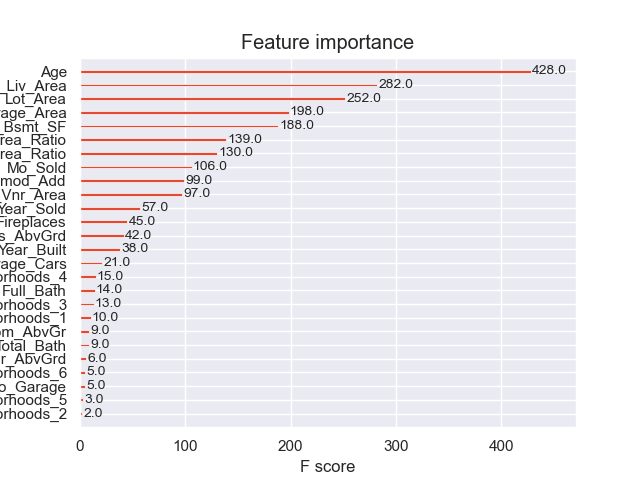

In [37]:
selected1 = plot_xgb_importance(dataset = df1.loc[:, subset], target = 'Sale_Price', ignore=None)

In [38]:
# plot_xgb_importance(dataset = df_orig1.loc[:, subset], target = 'Sale_Price', ignore = None)

Sembra soddisfacente, ma cerchiamo ora di capire cosa sceglierebbe l'algoritmo

<IPython.core.display.Javascript object>


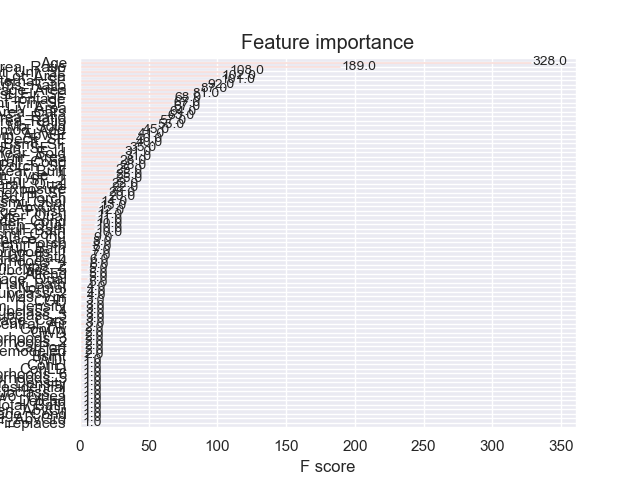

In [39]:
selected2 = plot_xgb_importance(dataset = df1, target = 'Sale_Price', ignore = 'Log1p_Sale_Price')

<IPython.core.display.Javascript object>


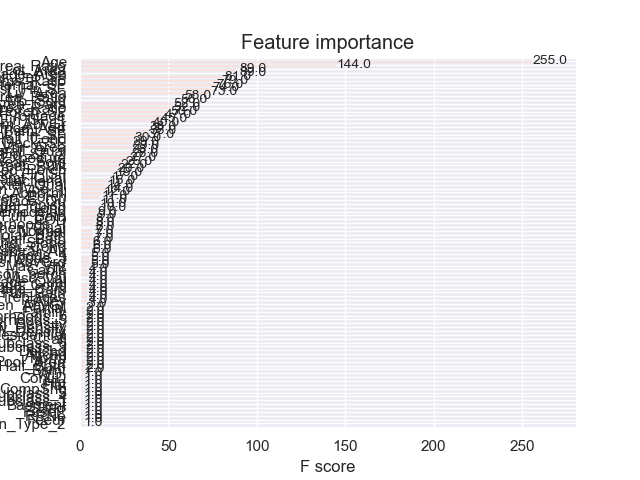

['Age',
 'Alley',
 'Bedroom_AbvGr',
 'Bedroom_Liv_Area_Ratio',
 'Bsmt',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'BsmtFin_Type_1',
 'BsmtFin_Type_2',
 'Bsmt_Cond',
 'Bsmt_Exposure',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Bsmt_Qual',
 'Bsmt_Unf_SF',
 'Central_Air',
 'Enclosed_Porch',
 'Exter_Cond',
 'Exter_Qual',
 'External_SF',
 'Fireplace_Gr_Area_Ratio',
 'Fireplace_Qu',
 'Fireplaces',
 'First_Flr_SF',
 'Flr_AbvGrd',
 'Full_Bath',
 'Functional',
 'Garage_Area',
 'Garage_Cars',
 'Garage_Cond',
 'Garage_Finish',
 'Garage_Qual',
 'Gr_Area_Rms_Ratio',
 'Gr_Liv_Area',
 'Half_Bath',
 'Kitchen_AbvGr',
 'Kitchen_Qual',
 'Land_Slope',
 'Log1p_Bsmt_Unf_SF',
 'Log1p_First_Flr_SF',
 'Log1p_Gr_Liv_Area',
 'Log1p_Total_Bsmt_SF',
 'Lot_Area',
 'Lot_Frontage',
 'LowQ_Total_Liv_Ratio',
 'Low_Qual_Fin_SF',
 'Mas_Vnr',
 'Mas_Vnr_Area',
 'Misc_Val',
 'Mo_Sold',
 'Open_Porch_SF',
 'Overall_Cond',
 'Overall_Qual',
 'Pool_Area',
 'Pool_QC',
 'Ratio_GarArea_Cars',
 'Remodeled',
 'Rms_Gr_Area_Ratio',
 'Screen_Porc

In [40]:
plot_xgb_importance(dataset = df_orig1, target = 'Sale_Price', ignore = 'Log1p_Sale_Price')

## Recursive Feature Elimination

In [65]:
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

def rfe_estim(dataset, target, estimator, cv, ignore=None):
    X, y = get_X_y(dataset=dataset, label=target, ignore=ignore)
    selector = RFECV(estimator=estimator, 
                     step=1, 
                     min_features_to_select=30, 
                     cv= cv, 
                     scoring='neg_mean_squared_error', 
                     n_jobs=-1, importance_getter='auto')
    selector = selector.fit(X, y)
    
    print('The optimal number of features is {}'.format(selector.n_features_))
    features = [f for f,s in zip(X.columns, selector.support_) if s]
    print('The selected features are:')
    print ('{}'.format(features))
    return features

In [66]:
xgb = XGBRegressor(n_estimators = 10,
                             max_depth = 12,
                             max_leaves = 12,
                             learning_rate = 0.5, 
                             importance_type = 'weight',
                             sampling_method = 'gradient_based', 
                             random_state = 292359329)
cv_rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)

In [67]:
f1 = rfe_estim(df1, target = 'Sale_Price', estimator = xgb, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 47
The selected features are:
['Age', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'Bsmt_Cond', 'Bsmt_Exposure', 'Bsmt_Full_Bath', 'Bsmt_Qual', 'Bsmt_Unf_SF', 'Enclosed_Porch', 'Exter_Cond', 'Exter_Qual', 'External_SF', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'First_Flr_SF', 'Garage_Area', 'Garage_Cars', 'Garage_Finish', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_Qual', 'Log1p_Total_Bsmt_SF', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr_Area', 'Mo_Sold', 'Open_Porch_SF', 'Overall_Cond', 'Overall_Qual', 'Ratio_GarArea_Cars', 'Screen_Porch', 'Second_Flr_SF', 'TBath_Gr_Area_Ratio', 'TotRms_AbvGrd', 'Total_Bath', 'Total_Bsmt_Fin_SF', 'Wood_Deck_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold', 'Residential_Low_Density', 'neighborhoods_3', 'neighborhoods_4']


In [68]:
f2 = rfe_estim(df_orig1, target = 'Sale_Price', estimator = xgb, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 56
The selected features are:
['Age', 'Alley', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'Bsmt_Cond', 'Bsmt_Exposure', 'Bsmt_Full_Bath', 'Bsmt_Qual', 'Bsmt_Unf_SF', 'Enclosed_Porch', 'Exter_Cond', 'Exter_Qual', 'External_SF', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'First_Flr_SF', 'Full_Bath', 'Functional', 'Garage_Area', 'Garage_Cars', 'Garage_Cond', 'Garage_Finish', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_Qual', 'Land_Slope', 'Log1p_Total_Bsmt_SF', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr_Area', 'Mo_Sold', 'Open_Porch_SF', 'Overall_Cond', 'Overall_Qual', 'Ratio_GarArea_Cars', 'Remodeled', 'Screen_Porch', 'Second_Flr_SF', 'TBath_Gr_Area_Ratio', 'TotRms_AbvGrd', 'Total_Bsmt_Fin_SF', 'Wood_Deck_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold', 'Residential_Low_Density', 'neighborhoods_1', 'neighborhoods_4', 'Gable', 'Abnorml', 'Family', 'WD ']


In [69]:
f3 = rfe_estim(df_alt.select_dtypes(exclude=object), target = 'Sale_Price', estimator = xgb, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 38
The selected features are:
['Age', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'Bsmt_Exposure', 'Bsmt_Qual', 'Bsmt_Unf_SF', 'Enclosed_Porch', 'Exter_Qual', 'External_SF', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'First_Flr_SF', 'Garage_Area', 'Garage_Finish', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Kitchen_Qual', 'Log1p_Total_Bsmt_SF', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr_Area', 'Mo_Sold', 'Open_Porch_SF', 'Overall_Cond', 'Overall_Qual', 'Ratio_GarArea_Cars', 'Second_Flr_SF', 'TBath_Gr_Area_Ratio', 'TotRms_AbvGrd', 'Total_Bsmt_Fin_SF', 'Wood_Deck_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold', 'neighborhoods_4']


In [70]:
f4 = rfe_estim(df_orig_alt.select_dtypes(exclude=object), target = 'Sale_Price', estimator = xgb, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 63
The selected features are:
['Age', 'Alley', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Cond', 'Bsmt_Exposure', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bsmt_Qual', 'Bsmt_Unf_SF', 'Enclosed_Porch', 'Exter_Cond', 'Exter_Qual', 'External_SF', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Full_Bath', 'Functional', 'Garage_Area', 'Garage_Cars', 'Garage_Cond', 'Garage_Finish', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_Qual', 'Land_Slope', 'Log1p_Total_Bsmt_SF', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr', 'Mas_Vnr_Area', 'Mo_Sold', 'Open_Porch_SF', 'Overall_Cond', 'Overall_Qual', 'Ratio_GarArea_Cars', 'Remodeled', 'Screen_Porch', 'Second_Flr_SF', 'TBath_Gr_Area_Ratio', 'TotRms_AbvGrd', 'Total_Bsmt_Fin_SF', 'Wood_Deck_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold', 'Residential_Low_Density', 'Residential_Medium_Density', 'neighborhoods_1', 'neighbo

In [71]:
rf = RandomForestRegressor(n_estimators=20,
                           max_depth=12, 
                           min_samples_split=10, 
                           min_samples_leaf=12, 
                           max_features=1.0, 
                           max_leaf_nodes=15, 
                           bootstrap=True, 
                           n_jobs=-1, 
                           random_state=2546243645, 
                           verbose=0)

In [72]:
f5 = rfe_estim(df1, target = 'Sale_Price', estimator = rf, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 91
The selected features are:
['Age', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Bsmt', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Cond', 'Bsmt_Exposure', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bsmt_Qual', 'Bsmt_Unf_SF', 'Central_Air', 'Enclosed_Porch', 'Exter_Cond', 'Exter_Qual', 'External_SF', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Flr_AbvGrd', 'Full_Bath', 'Garage_Area', 'Garage_Cars', 'Garage_Cond', 'Garage_Finish', 'Garage_Qual', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_AbvGr', 'Kitchen_Qual', 'Log1p_Bsmt_Unf_SF', 'Log1p_First_Flr_SF', 'Log1p_Gr_Liv_Area', 'Log1p_Total_Bsmt_SF', 'Lot_Area', 'Lot_Frontage', 'LowQ_Total_Liv_Ratio', 'Low_Qual_Fin_SF', 'Mas_Vnr', 'Mas_Vnr_Area', 'Overall_Qual', 'Rms_Gr_Area_Ratio', 'Screen_Porch', 'Second_Flr_SF', 'TBath_Gr_Area_Ratio', 'Three_season_porch', 'TotRms_AbvGrd', 'Total_Bath', 'Total_Bsmt_Fin_SF', 'Total_Bsmt_SF', 'Wood_Deck_

In [73]:
f6 = rfe_estim(df_orig1, target = 'Sale_Price', estimator = rf, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 30
The selected features are:
['Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Bsmt_Cond', 'Bsmt_Qual', 'Bsmt_Unf_SF', 'Fireplace_Gr_Area_Ratio', 'First_Flr_SF', 'Garage_Area', 'Garage_Cars', 'Garage_Finish', 'Gr_Liv_Area', 'Kitchen_Qual', 'Log1p_First_Flr_SF', 'Log1p_Gr_Liv_Area', 'Log1p_Total_Bsmt_SF', 'Lot_Area', 'Open_Porch_SF', 'Overall_Qual', 'Ratio_GarArea_Cars', 'TBath_Gr_Area_Ratio', 'Total_Bath', 'Total_Bsmt_Fin_SF', 'Total_Bsmt_SF', 'Wood_Deck_SF', 'Year_Built', 'Year_Remod_Add', 'ms_subclass_1', 'neighborhoods_1', 'neighborhoods_6', 'Partial']


In [74]:
f7 = rfe_estim(df_alt.select_dtypes(exclude=object), target = 'Sale_Price', estimator = rf, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 78
The selected features are:
['Age', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Cond', 'Bsmt_Exposure', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bsmt_Qual', 'Bsmt_Unf_SF', 'Enclosed_Porch', 'Exter_Cond', 'Exter_Qual', 'External_SF', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Flr_AbvGrd', 'Full_Bath', 'Garage_Area', 'Garage_Cars', 'Garage_Cond', 'Garage_Finish', 'Garage_Qual', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_AbvGr', 'Kitchen_Qual', 'Log1p_Bsmt_Unf_SF', 'Log1p_First_Flr_SF', 'Log1p_Gr_Liv_Area', 'Log1p_Total_Bsmt_SF', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr_Area', 'Overall_Qual', 'Screen_Porch', 'Second_Flr_SF', 'TBath_Gr_Area_Ratio', 'Three_season_porch', 'TotRms_AbvGrd', 'Total_Bath', 'Total_Bsmt_Fin_SF', 'Total_Bsmt_SF', 'Wood_Deck_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detc

In [75]:
f8 = rfe_estim(df_orig_alt.select_dtypes(exclude=object), target = 'Sale_Price', estimator =rf, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 30
The selected features are:
['Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Bsmt_Qual', 'Fireplace_Gr_Area_Ratio', 'First_Flr_SF', 'Garage_Area', 'Garage_Cars', 'Garage_Finish', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Kitchen_Qual', 'Log1p_Bsmt_Unf_SF', 'Log1p_First_Flr_SF', 'Log1p_Gr_Liv_Area', 'Log1p_Total_Bsmt_SF', 'Lot_Area', 'Open_Porch_SF', 'Overall_Qual', 'Ratio_GarArea_Cars', 'TBath_Gr_Area_Ratio', 'Total_Bath', 'Total_Bsmt_Fin_SF', 'Total_Bsmt_SF', 'Wood_Deck_SF', 'Year_Built', 'Year_Remod_Add', 'ms_subclass_1', 'neighborhoods_1', 'neighborhoods_6', 'Partial']


---

## Feature Selection

Now we shall find a compromise between all the features in order to save just the important ones for the boosted random forest.
For what concerns the GCN, we are going to add some more features since some of them are just the encoding of previous categorical features.

In [76]:
list(set(f1) & set(f2) & set(f3) & set(f4) & set(f5) & set(f6) & set(f7) & set(f8))

['Garage_Area',
 'Fireplace_Gr_Area_Ratio',
 'Lot_Area',
 'Overall_Qual',
 'Wood_Deck_SF',
 'Bsmt_Qual',
 'Year_Remod_Add',
 'Year_Built',
 'Total_Bsmt_Fin_SF',
 'TBath_Gr_Area_Ratio',
 'Log1p_Total_Bsmt_SF',
 'Bedroom_AbvGr',
 'Kitchen_Qual',
 'Garage_Finish',
 'Bedroom_Liv_Area_Ratio',
 'First_Flr_SF',
 'Gr_Liv_Area']

From all the analysis done until now, I personally believe this is the best subset to use

In [88]:
subset = ['Sale_Price', 
          'Age', 'Year_Built', 'Year_Remod_Add',
          
          'First_Flr_SF', 'Flr_AbvGrd', 'TotRms_AbvGrd',
          
          'Bedroom_AbvGr','Bedroom_Liv_Area_Ratio',
          
          'Bsmt_Cond','Total_Bsmt_SF','Bsmt_Exposure',
          'Bsmt_Full_Bath','Bsmt_Half_Bath', 'Bsmt_Qual',
           
          'TBath_Gr_Area_Ratio', 'Total_Bath',
          
          'Exter_Cond','Exter_Qual','External_SF',
          
          'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 
          
          'Garage_Area','Garage_Cars','Garage_Cond',
          'Garage_Finish', 'Garage_Qual','No_Garage',
          
          'Gr_Area_Rms_Ratio','Gr_Liv_Area',
          
          'Kitchen_AbvGr', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr_Area', 
          
          'Year_Sold','Mo_Sold',
          
          'neighborhoods_1', 'neighborhoods_2', 'neighborhoods_3', 
          'neighborhoods_4', 'neighborhoods_5', 'neighborhoods_6']

In [96]:
df1.loc[:, subset].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sale_Price               2638 non-null   float64
 1   Age                      2638 non-null   float64
 2   Year_Built               2638 non-null   float64
 3   Year_Remod_Add           2638 non-null   float64
 4   First_Flr_SF             2638 non-null   float64
 5   Flr_AbvGrd               2638 non-null   int64  
 6   TotRms_AbvGrd            2638 non-null   float64
 7   Bedroom_AbvGr            2638 non-null   float64
 8   Bedroom_Liv_Area_Ratio   2638 non-null   float64
 9   Bsmt_Cond                2638 non-null   float64
 10  Total_Bsmt_SF            2638 non-null   float64
 11  Bsmt_Exposure            2638 non-null   float64
 12  Bsmt_Full_Bath           2638 non-null   float64
 13  Bsmt_Half_Bath           2638 non-null   float64
 14  Bsmt_Qual               

In [95]:
df_orig1.loc[:, subset].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sale_Price               2930 non-null   float64
 1   Age                      2930 non-null   float64
 2   Year_Built               2930 non-null   float64
 3   Year_Remod_Add           2930 non-null   float64
 4   First_Flr_SF             2930 non-null   float64
 5   Flr_AbvGrd               2930 non-null   int64  
 6   TotRms_AbvGrd            2930 non-null   float64
 7   Bedroom_AbvGr            2930 non-null   float64
 8   Bedroom_Liv_Area_Ratio   2930 non-null   float64
 9   Bsmt_Cond                2930 non-null   float64
 10  Total_Bsmt_SF            2930 non-null   float64
 11  Bsmt_Exposure            2930 non-null   float64
 12  Bsmt_Full_Bath           2930 non-null   float64
 13  Bsmt_Half_Bath           2930 non-null   float64
 14  Bsmt_Qual               

We are going to proceed now with a type conversion

In [97]:
df1 = df1.loc[:, subset]
df_orig1 = df_orig1.loc[:, subset]

---

## Type Conversion


Type conversion is one key step to ensure fast computing, and is possible when the types used for some columns do not match the way their values were meant to be represented by.

In our case, some of these numeric columns are represented through `float64` type which seems to be too computationally expensive, provided they are meant to take values which do not require that level precision. It is probably best have all `float32` as it seems a good trade off between precision and space.

In [99]:
def set_labels_type(dataset, labels, np_type):
    type_dict = {}
    for i in labels:
        type_dict.update({i:np_type})
    return dataset.astype(type_dict)

In [102]:
df1 = set_labels_type(df1, labels= subset, np_type='float32')
df_orig1 = set_labels_type(df_orig1, labels= subset, np_type='float32')


### Save the dataset

In [103]:
df1.to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_2.csv"))
df_orig1.to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_2_orig.csv"))